
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
import datetime as dt

from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

##New libraries used
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

pd.options.display.max_columns = None

In [19]:
df_econ = pd.read_csv(r'C:\Users\Trevr\Desktop\NYSE_IPYNB\stock_data\econ.csv')
df_econ.head(2)

,Period,ConsConf,CompLead,BusConf,Emp,InvToSales,PMI,SP500,MfgOrdDur,BldgPerm,Sales,FedFunds,DJI,Payroll,PersCons
0,2007-01,100.8497,101.4669,99.40803,72.11646,1.31,49.5,1424.16,217697,1626,327125,5.25,12621.69,135335,9553.1
1,2007-02,100.6274,101.5683,99.51553,71.97358,1.30,51.9,1444.80,222033,1598,328076,5.26,12268.63,136026,9590.8


In [27]:
df_fun = pd.read_csv(r'C:\Users\Trevr\Desktop\NYSE_IPYNB\stock_data\fundamentals.csv')
df_fun.head(2)

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08


In [21]:
df_prices = pd.read_csv(r'C:\Users\Trevr\Desktop\NYSE_IPYNB\stock_data\prices-split-adjusted.csv')
df_prices.head(2)

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0


In [22]:
df_sec = pd.read_csv(r'C:\Users\Trevr\Desktop\NYSE_IPYNB\stock_data\securities.csv')
df_sec.head(2)

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800


In [13]:
def RSI(series, period=14):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com = period-1,adjust = False).mean()/d.ewm(com = period-1,adjust = False).mean() 
    return 100 - 100 / (1 + rs)

In [14]:
def moving_average_convergence(group, nslow=26, nfast=12):
    emaslow = group.ewm(span=nslow, min_periods=1).mean()
    emafast = group.ewm(span=nfast, min_periods=1).mean()
    result = pd.DataFrame({'MACD': emafast-emaslow, 'ema_slow': emaslow, 'ema_fast': emafast})
    return result

In [216]:
def wrangle_and_merge(prices_df, fund_df, sec_df, econ_df):
  x_price = prices_df.copy()
  x_fun = fund_df.copy()
  x_sec = sec_df.copy()
  x_econ = econ_df.copy()

  #Change to numeric datetime format
  x_price['date'] = pd.to_datetime(x_price['date'])
  #Add year column for merging into fundamentals
  #x_price['year'] = x_price['date'].map(lambda x: x.year)
  x_price['year'] = x_price['date'].dt.year
  #x_price['month'] = x_price['date'].map(lambda x: x.month)
  x_price['month'] = x_price['date'].dt.month
  #x_price['day'] = x_price['date'].map(lambda x: x.day)
  x_price['day'] = x_price['date'].dt.day
  #change date to numeric for model purposes
  x_price['date'] = x_price['date'].map(lambda x: x.value)

  x_econ['Period'] = pd.to_datetime(x_econ['Period'])
  #x_econ['year'] = x_econ['Period'].map(lambda x: x.year)
  x_econ['year'] = x_econ['Period'].dt.year
  #x_econ['month'] = x_econ['Period'].map(lambda x: x.month)
  x_econ['month'] = x_econ['Period'].dt.month
  x_econ = x_econ.drop(columns='Period')

  x_fun['Period Ending'] = pd.to_datetime(x_fun['Period Ending']).map(lambda x: x.value)
  #year incremented by 1
  x_fun['year'] = x_fun['For Year'].map(lambda x: x+1)

  x_fun = x_fun.drop(columns='Unnamed: 0')

  merged_df = x_price

  #Only grab columns we need
  x_sec = x_sec[['Ticker symbol', 'GICS Sector', 'GICS Sub Industry']]

  #Rename columns for merging
  x_sec = x_sec.rename(columns={'Ticker symbol':'symbol'})
  #x_fun = x_fun.rename(columns={'For Year':'year'})
  x_fun = x_fun.rename(columns={'Ticker Symbol':'symbol'})

  #Add sector information to stocks
  merged_df = merged_df.merge(x_sec, on='symbol', how='inner')

  #Add fundamentals to stock info
  merged_df = merged_df.merge(x_fun, on=['symbol', 'year'], how='inner')

  #Add economics data to stocks
  merged_df = merged_df.merge(x_econ, on=['year', 'month'], how='left')

  #Feature Engineering calculating daily percent change
  merged_df['percent_change'] = merged_df.groupby('symbol')['open'].pct_change()
  merged_df['percent_change'] = merged_df['percent_change'].fillna(0)

  #Feature engineering calculating cumulative returns
  merged_df['returns'] = merged_df['percent_change'] + 1
  merged_df['returns'] = merged_df.groupby('symbol')['returns'].cumprod()
    
  #Fix this (need to figure out how to add + 1 before calling rolling(10))
  merged_df['rolling_percent_change_cumprod'] = (merged_df.groupby('symbol')['open'].pct_change() + 1
                                                .fillna(0)).rolling(10).mean().cumsum()

  #Feature engineer calculating volatility in annualized terms of percent changes in price
  window_size = 10
  #merged_df['volatility'] = merged_df.groupby('symbol')['open'].pct_change().rolling(window_size).std()*(252**.05)
  #Note: this applies the same as above, but nice to see they both work as intended
  merged_df['volatility'] = merged_df.groupby('symbol')['open'].apply(lambda group: group.pct_change().rolling(window_size).std()*(252**.05))
  #merged_df['std_dev'] = merged_df.groupby('symbol')['open'].rolling(window_size).std()
  #merged_df['std_dev'] = merged_df.groupby('symbol')['std_dev'].transform(lambda x: x.fillna(x.mean()))

  #Note: these two commented out lines produce rolling average in 'symbols' alphabetical order, which is incorrect
  #ma_20 = merged_df.groupby('symbol')[open].rolling(window_size)['open'].mean()
  #merged_df['20_day_MA'] = ma_20.values
  merged_df['5_day_MA'] = merged_df.groupby('symbol')['open'].apply(lambda group: group.rolling(5).mean())
  merged_df['10_day_MA'] = merged_df.groupby('symbol')['open'].apply(lambda group: group.rolling(10).mean())
  merged_df['20_day_MA'] = merged_df.groupby('symbol')['open'].apply(lambda group: group.rolling(20).mean())
  merged_df['40_day_MA'] = merged_df.groupby('symbol')['open'].apply(lambda group: group.rolling(40).mean())
  #merged_df['Relative_Strength_Index'] = merged_df.groupby('symbol')['close'].apply(RSI)

  #Adds RSI to merged_df, RSI column is defined in far right of code where columns=...
  merged_df = merged_df.join(merged_df.groupby('symbol', sort=False)['close'].apply(RSI).to_frame().droplevel(0).rename(columns={'close':'RSI'}), how='left')

  #emaslow = merged_df.ewma(group, span=26, min_periods=1)
  #emafast = merged_df.ewma(group, span=12, min_periods=1)
  #merged_df['emaslow'] = emaslow
  #merged_df['emafast'] = emafast
  #merged_df['MACD'] = emafast-emaslow
  #result = merged_df.DataFrame({'MACD': emafast-emaslow, 'emaSlw': emaslow, 'emaFst': emafast})
  #merged_df[['MACD', 'EMA_slow', 'EMA_fast']] = merged_df.groupby('symbol')['open'].apply(moving_average_convergence)
  
  #Drop unnecessary columns
  merged_df = merged_df.drop(columns=['For Year', 'Period Ending', 'open', 'low', 'high'])
  return merged_df

In [16]:
def custom_imputer(X):
    X = X.copy()
    #Fill NA values by group mean
    X['RSI'] = X.groupby('symbol')['RSI'].apply(lambda group: group.interpolate(limit_direction='backward'))
    X['volatility'] = X.groupby('symbol')['volatility'].apply(lambda group: group.interpolate(limit_direction='backward'))
    X['rolling_percent_change_cumprod'] = X.groupby('symbol')['rolling_percent_change_cumprod'].apply(lambda group: group.interpolate(limit_direction='backward'))
    #X['5_day_MA'] = X.groupby('symbol')['5_day_MA'].apply(lambda group: group.interpolate(limit_direction='backward'))
    X['10_day_MA'] = X.groupby('symbol')['10_day_MA'].apply(lambda group: group.interpolate(limit_direction='backward'))
    X['20_day_MA'] = X.groupby('symbol')['20_day_MA'].apply(lambda group: group.interpolate(limit_direction='backward'))
    X['40_day_MA'] = X.groupby('symbol')['40_day_MA'].apply(lambda group: group.interpolate(limit_direction='backward'))
    X['Earnings Per Share'] = X.groupby(['GICS Sector','year'])['Earnings Per Share'].transform(lambda x: x.fillna(x.mean()))
    X['Estimated Shares Outstanding'] = X.groupby(['GICS Sector','year'])['Estimated Shares Outstanding'].transform(lambda x: x.fillna(x.mean()))
    X['Quick Ratio'] = X.groupby(['GICS Sector','year'])['Quick Ratio'].transform(lambda x: x.fillna(x.mean()))
    X['Cash Ratio'] = X.groupby(['GICS Sector','year'])['Cash Ratio'].transform(lambda x: x.fillna(x.mean()))
    X['Current Ratio'] = X.groupby(['GICS Sector','year'])['Current Ratio'].transform(lambda x: x.fillna(x.mean()))

    X['Earnings Per Share'] = X.groupby(['GICS Sector','year'])['Earnings Per Share'].transform(lambda x: x.fillna(x.mean()))
    X['Estimated Shares Outstanding'] = X.groupby(['GICS Sector','year'])['Estimated Shares Outstanding'].transform(lambda x: x.fillna(x.mean()))
    X['Quick Ratio'] = X.groupby(['GICS Sector','year'])['Quick Ratio'].transform(lambda x: x.fillna(x.mean()))
    X['Cash Ratio'] = X.groupby(['GICS Sector','year'])['Cash Ratio'].transform(lambda x: x.fillna(x.mean()))
    X['Current Ratio'] = X.groupby(['GICS Sector','year'])['Current Ratio'].transform(lambda x: x.fillna(x.mean()))
    
    return X

In [217]:
merged_df = wrangle_and_merge(df_prices, df_fun, df_sec, df_econ)
merged_df.head(3)

AttributeError: 'int' object has no attribute 'fillna'

In [245]:
def model_builder(df, target, features_arr):
    X = df[features_arr]
    y = df[target]
    
    temp = pd.to_datetime(df['date'])
    mask = temp <= dt.datetime(2015,1,1)
    mask_not = ~mask
    
    X_train = X[mask]
    y_train = y[mask]
    
    X_val = X[mask_not]
    y_val = y[mask_not]
    
    #Create specific stocks to predict on above data
    X_specific_stock_val = X_val[X_val['symbol'].isin(['WMT'])]
    
    #Transform on customer imputer I built
    X_train = custom_imputer(X_train)
    X_val = custom_imputer(X_val)
    X_specific_stock_val = custom_imputer(X_specific_stock_val)
    
    #Refit y index values to transformed dataset
    y_train = y_train[y_train.index.isin(X_train.index)]
    y_val = y_val[y_val.index.isin(X_val.index)]
    y_specific_stock_val = y_val[y_val.index.isin(X_specific_stock_val.index)]
    
    
    model = make_pipeline(ce.BinaryEncoder(),
                         SimpleImputer(strategy='mean'),
                         RandomForestRegressor(random_state=42, n_jobs=-1))
    
    #XGBRegressor(n_jobs=2)
    
    params = {'randomforestregressor__n_estimators': range(5,76,15), #4 options
            'randomforestregressor__max_depth': range(1,8,3)} #3 options
    
    #Create gridsearch
    search = RandomizedSearchCV(
      model,
      param_distributions=params,
      n_iter=7,
      cv=10,
      scoring=None,
      verbose=10,
      return_train_score=True,
      n_jobs=-1
      )

    search.fit(X_train,y_train)
    
    model = search.best_estimator_
    
    y_pred = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_spec_stock_pred = model.predict(X_specific_stock_val)
    
    print("Baseline Accuracy:", y_train.value_counts(normalize=True).max())
    print('Training Score:', model.score(X_train, y_train))
    print('Validation Score:', model.score(X_val, y_val))
    
    #plt.subplots(figsize=(10,5))
    #plt.plot(range(0,len(y_specific_stock_val)), y_specific_stock_val)
    #plt.plot(range(0,len(y_spec_stock_pred)), y_spec_stock_pred)
    #plt.legend(['Actual', 'Predicted'])
    #plt.plot()
    
    #feature = 'RSI'
    
    #isolated = pdp_isolate(
    #    model = model,
    #    dataset = X_val,
    #    model_features=X_val.columns,
    #    feature=feature
    #)
    
    #pdp_plot(isolated, feature_name=feature)
    
    return X_train, X_val, y_train, y_val, model
    

In [187]:
target = 'volume'
features = merged_df.columns.drop(target)
features

Index(['date', 'symbol', 'close', 'year', 'month', 'day', 'GICS Sector',
       'GICS Sub Industry', 'Accounts Payable', 'Accounts Receivable',
       ...
       'PersCons', 'percent_change', 'returns',
       'rolling_percent_change_cumprod', 'volatility', '5_day_MA', '10_day_MA',
       '20_day_MA', '40_day_MA', 'RSI'],
      dtype='object', length=106)

In [173]:
df_subsection = merged_df[merged_df['symbol'].isin(['MSFT', 'AAPL', 'AVB', 'TSLA', 'AMZN', 
                                                    'NFLX', 'HD', 'WMT', 'CCI', 'WM', 'AEP', 
                                                    'BP', 'MU', 'GOOG', 'GE', 'AMGN'])]
df_subsection['symbol'].value_counts()

AVB     1008
CCI     1008
HD      1008
MU       756
WM       756
AAPL     756
AEP      756
AMZN     756
WMT      756
AMGN     756
MSFT     756
NFLX     756
Name: symbol, dtype: int64

In [246]:
X_train, X_val, y_train, y_val, model = model_builder(df_subsection, target, features)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    7.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    7.6s finished


Baseline Accuracy: 0.000744047619047619
Training Score: 0.8540109194075797
Validation Score: 0.5051544617574985


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d3d5d3048>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d2ae39888>})

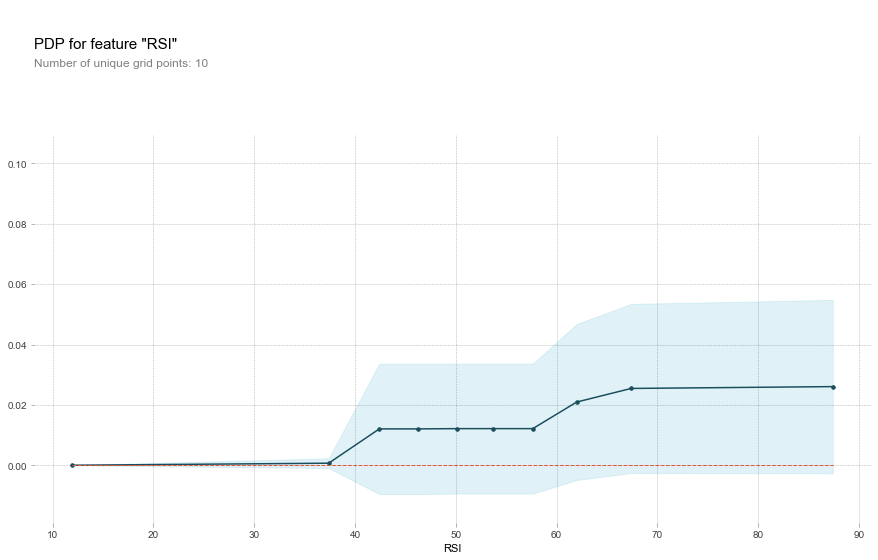

In [180]:
feature = 'RSI'
    
isolated = pdp_isolate(
    model = model,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)
    
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d28401ec8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d3ceb4e88>})

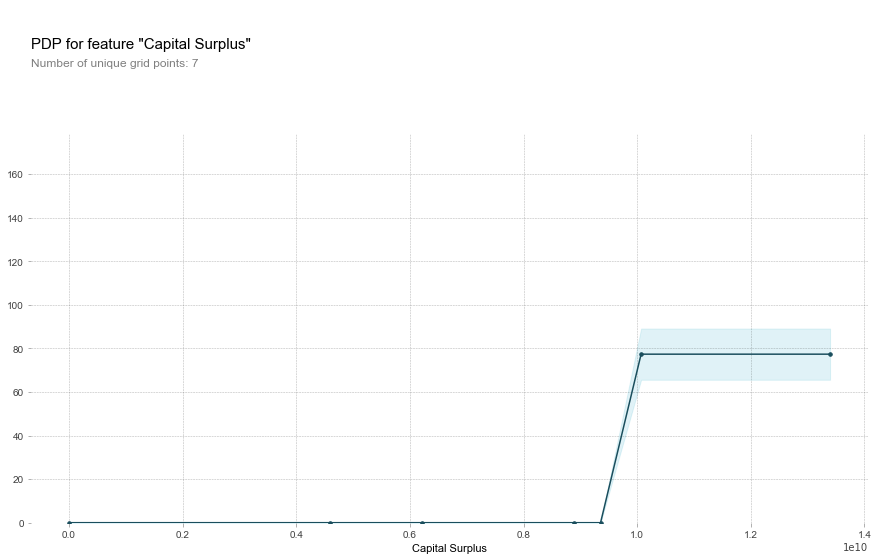

In [148]:
feature = 'Capital Surplus'
    
isolated = pdp_isolate(
    model = model,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)
    
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d2ae4db48>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d2c426988>})

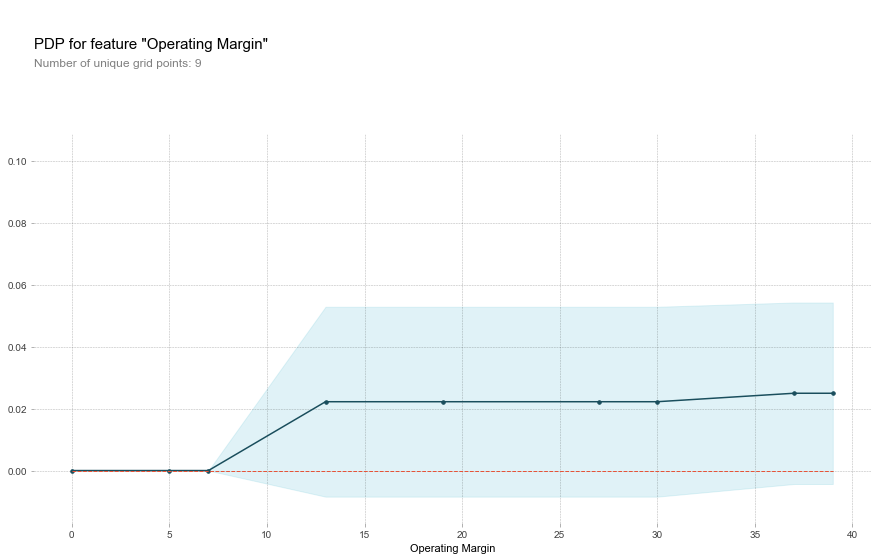

In [181]:
feature = 'Operating Margin'
    
isolated = pdp_isolate(
    model = model,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)
    
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d2f758408>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d40eaca48>})

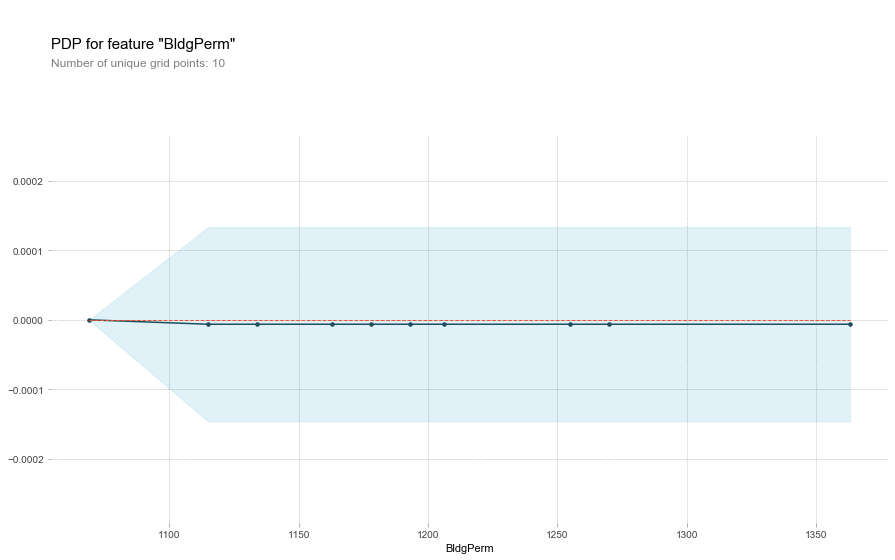

In [182]:
feature = 'BldgPerm'
    
isolated = pdp_isolate(
    model = model,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)
    
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d2f758d48>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d2a928108>})

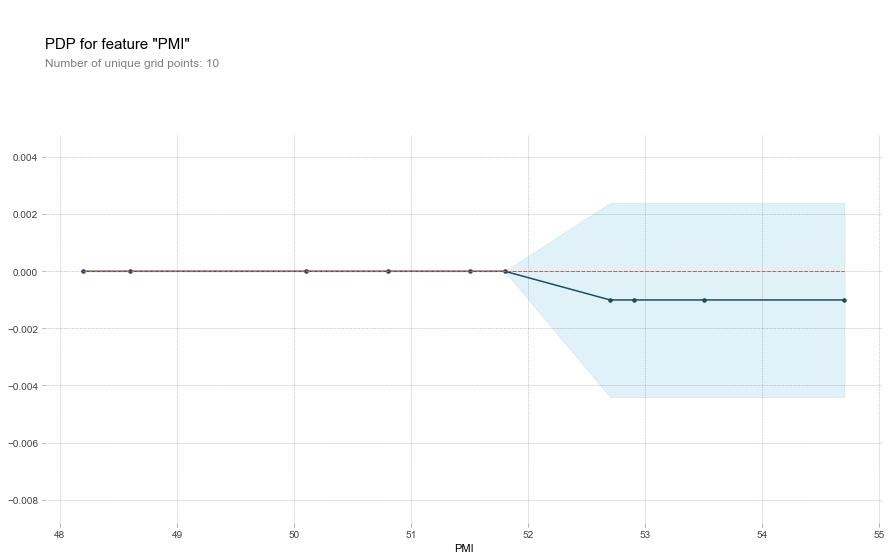

In [183]:
feature = 'PMI'
    
isolated = pdp_isolate(
    model = model,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)
    
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d2a22a2c8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d28885548>})

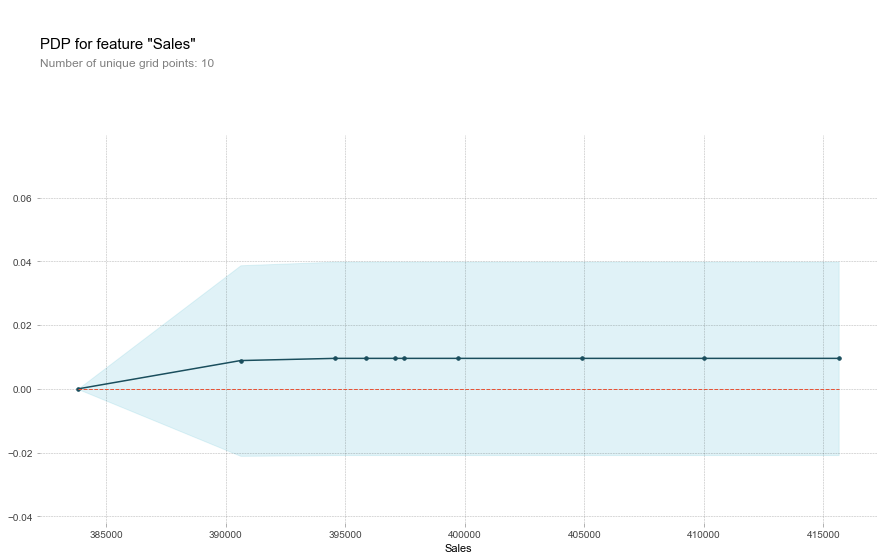

In [158]:
feature = 'Sales'
    
isolated = pdp_isolate(
    model = model,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)
    
pdp_plot(isolated, feature_name=feature)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d28e2f488>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d288090c8>})

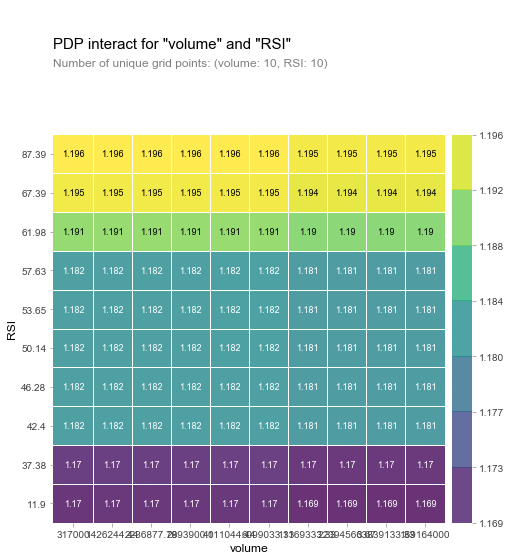

In [184]:
features = ['volume', 'RSI']

interaction = pdp_interact(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d2a7df308>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d28db6f88>})

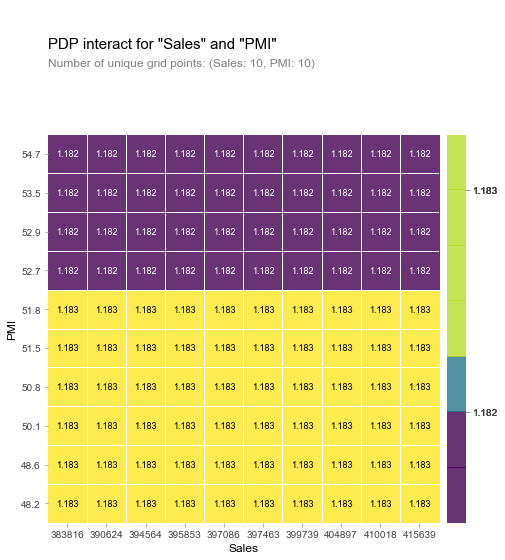

In [185]:
features = ['Sales', 'PMI']

interaction = pdp_interact(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d28dba3c8>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21d2a593e08>})

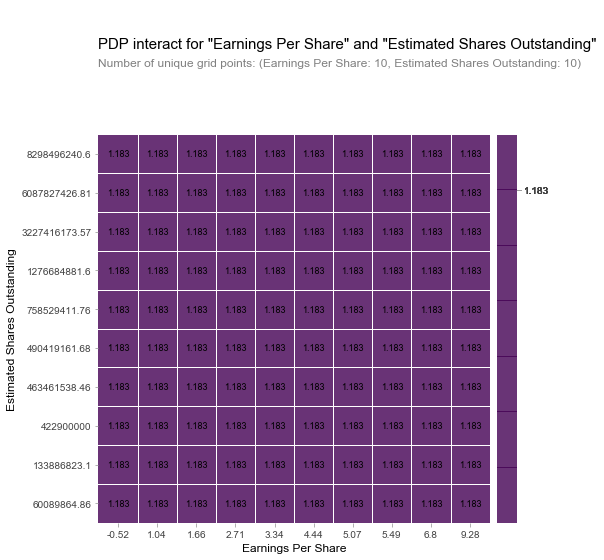

In [186]:
features = ['Earnings Per Share', 'Estimated Shares Outstanding']

interaction = pdp_interact(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

In [195]:
import shap

In [238]:
temp = ce.BinaryEncoder().fit(X_val).transform(X_val)
temp.head(2)

,date,symbol_0,symbol_1,symbol_2,symbol_3,symbol_4,close,year,month,day,...,PersCons,percent_change,returns,rolling_percent_change_cumprod,volatility,5_day_MA,10_day_MA,20_day_MA,40_day_MA,RSI
2519,1420156800000000000,0,0,0,0,1,109.330002,2015,1,2,...,12088.3,-0.012675,1.403200,0.0,0.021532,112.747999,112.584001,112.160501,112.97425,42.591853
2520,1420416000000000000,0,0,0,0,1,106.250000,2015,1,5,...,12088.3,-0.027830,1.364148,-0.0,0.015662,111.986000,112.226001,111.786501,112.95400,36.099543


In [249]:
applicant_profiler = temp.iloc[[10]]
applicant_profiler

,date,symbol_0,symbol_1,symbol_2,symbol_3,symbol_4,close,year,month,day,GICS Sector_0,GICS Sector_1,GICS Sector_2,GICS Sector_3,GICS Sub Industry_0,GICS Sub Industry_1,GICS Sub Industry_2,GICS Sub Industry_3,GICS Sub Industry_4,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,Earnings Per Share,Estimated Shares Outstanding,ConsConf,CompLead,BusConf,Emp,InvToSales,PMI,SP500,MfgOrdDur,BldgPerm,Sales,FedFunds,DJI,Payroll,PersCons,percent_change,returns,rolling_percent_change_cumprod,volatility,5_day_MA,10_day_MA,20_day_MA,40_day_MA,RSI
2529,1421366400000000000,0,0,0,0,1,105.989998,2015,1,16,0,0,0,1,0,0,0,0,1,4.864900e+10,-6.452000e+09,980000000.0,35.0,-9.571000e+09,0.0,40.0,1.384400e+10,-76000000.0,2.331300e+10,1.122580e+11,108.0,0.0,3.031000e+09,7.946000e+09,5.348300e+10,5.348300e+10,0.0,0.0,2.062400e+10,4.616000e+09,39.0,7.053700e+10,1.397300e+10,4.142000e+09,0.0,2.111000e+09,-9.027000e+09,1.340800e+10,2.898700e+10,1.301620e+11,0.0,0.0,1.826600e+10,-415000000.0,5.971300e+10,-3.754900e+10,-2.257900e+10,3.951000e+10,5.210000e+09,3.951000e+10,3.951000e+10,3.153700e+10,0.0,5.250300e+10,29.0,3.764000e+09,9.806000e+09,8.491000e+09,1.082000e+09,-1.158000e+09,-3.981000e+09,2.482600e+10,167000000.0,0.0,29.0,48.0,22.0,105.0,6.041000e+09,8.715200e+10,-4.427000e+10,1.199300e+10,6.308000e+09,1.123300e+10,2.318390e+11,6.853100e+10,6.344800e+10,1.115470e+11,1.202920e+11,2.318390e+11,1.827950e+11,0.0,6.49,6.087827e+09,101.0702,100.7195,100.2068,68.52348,1.37,53.5,2028.18,226806,1069,385630,0.11,17164.95,138511,12088.3,-0.027,1.348276,0.0,0.026569,110.02,109.403,110.9935,112.65725,39.203974


In [247]:
explainer = shap.TreeExplainer(model[2])
applicant_profiler = temp.iloc[[10]]
shap_values = explainer.shap_values(applicant_profiler)
shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values=shap_values,
    features=applicant_profiler
)

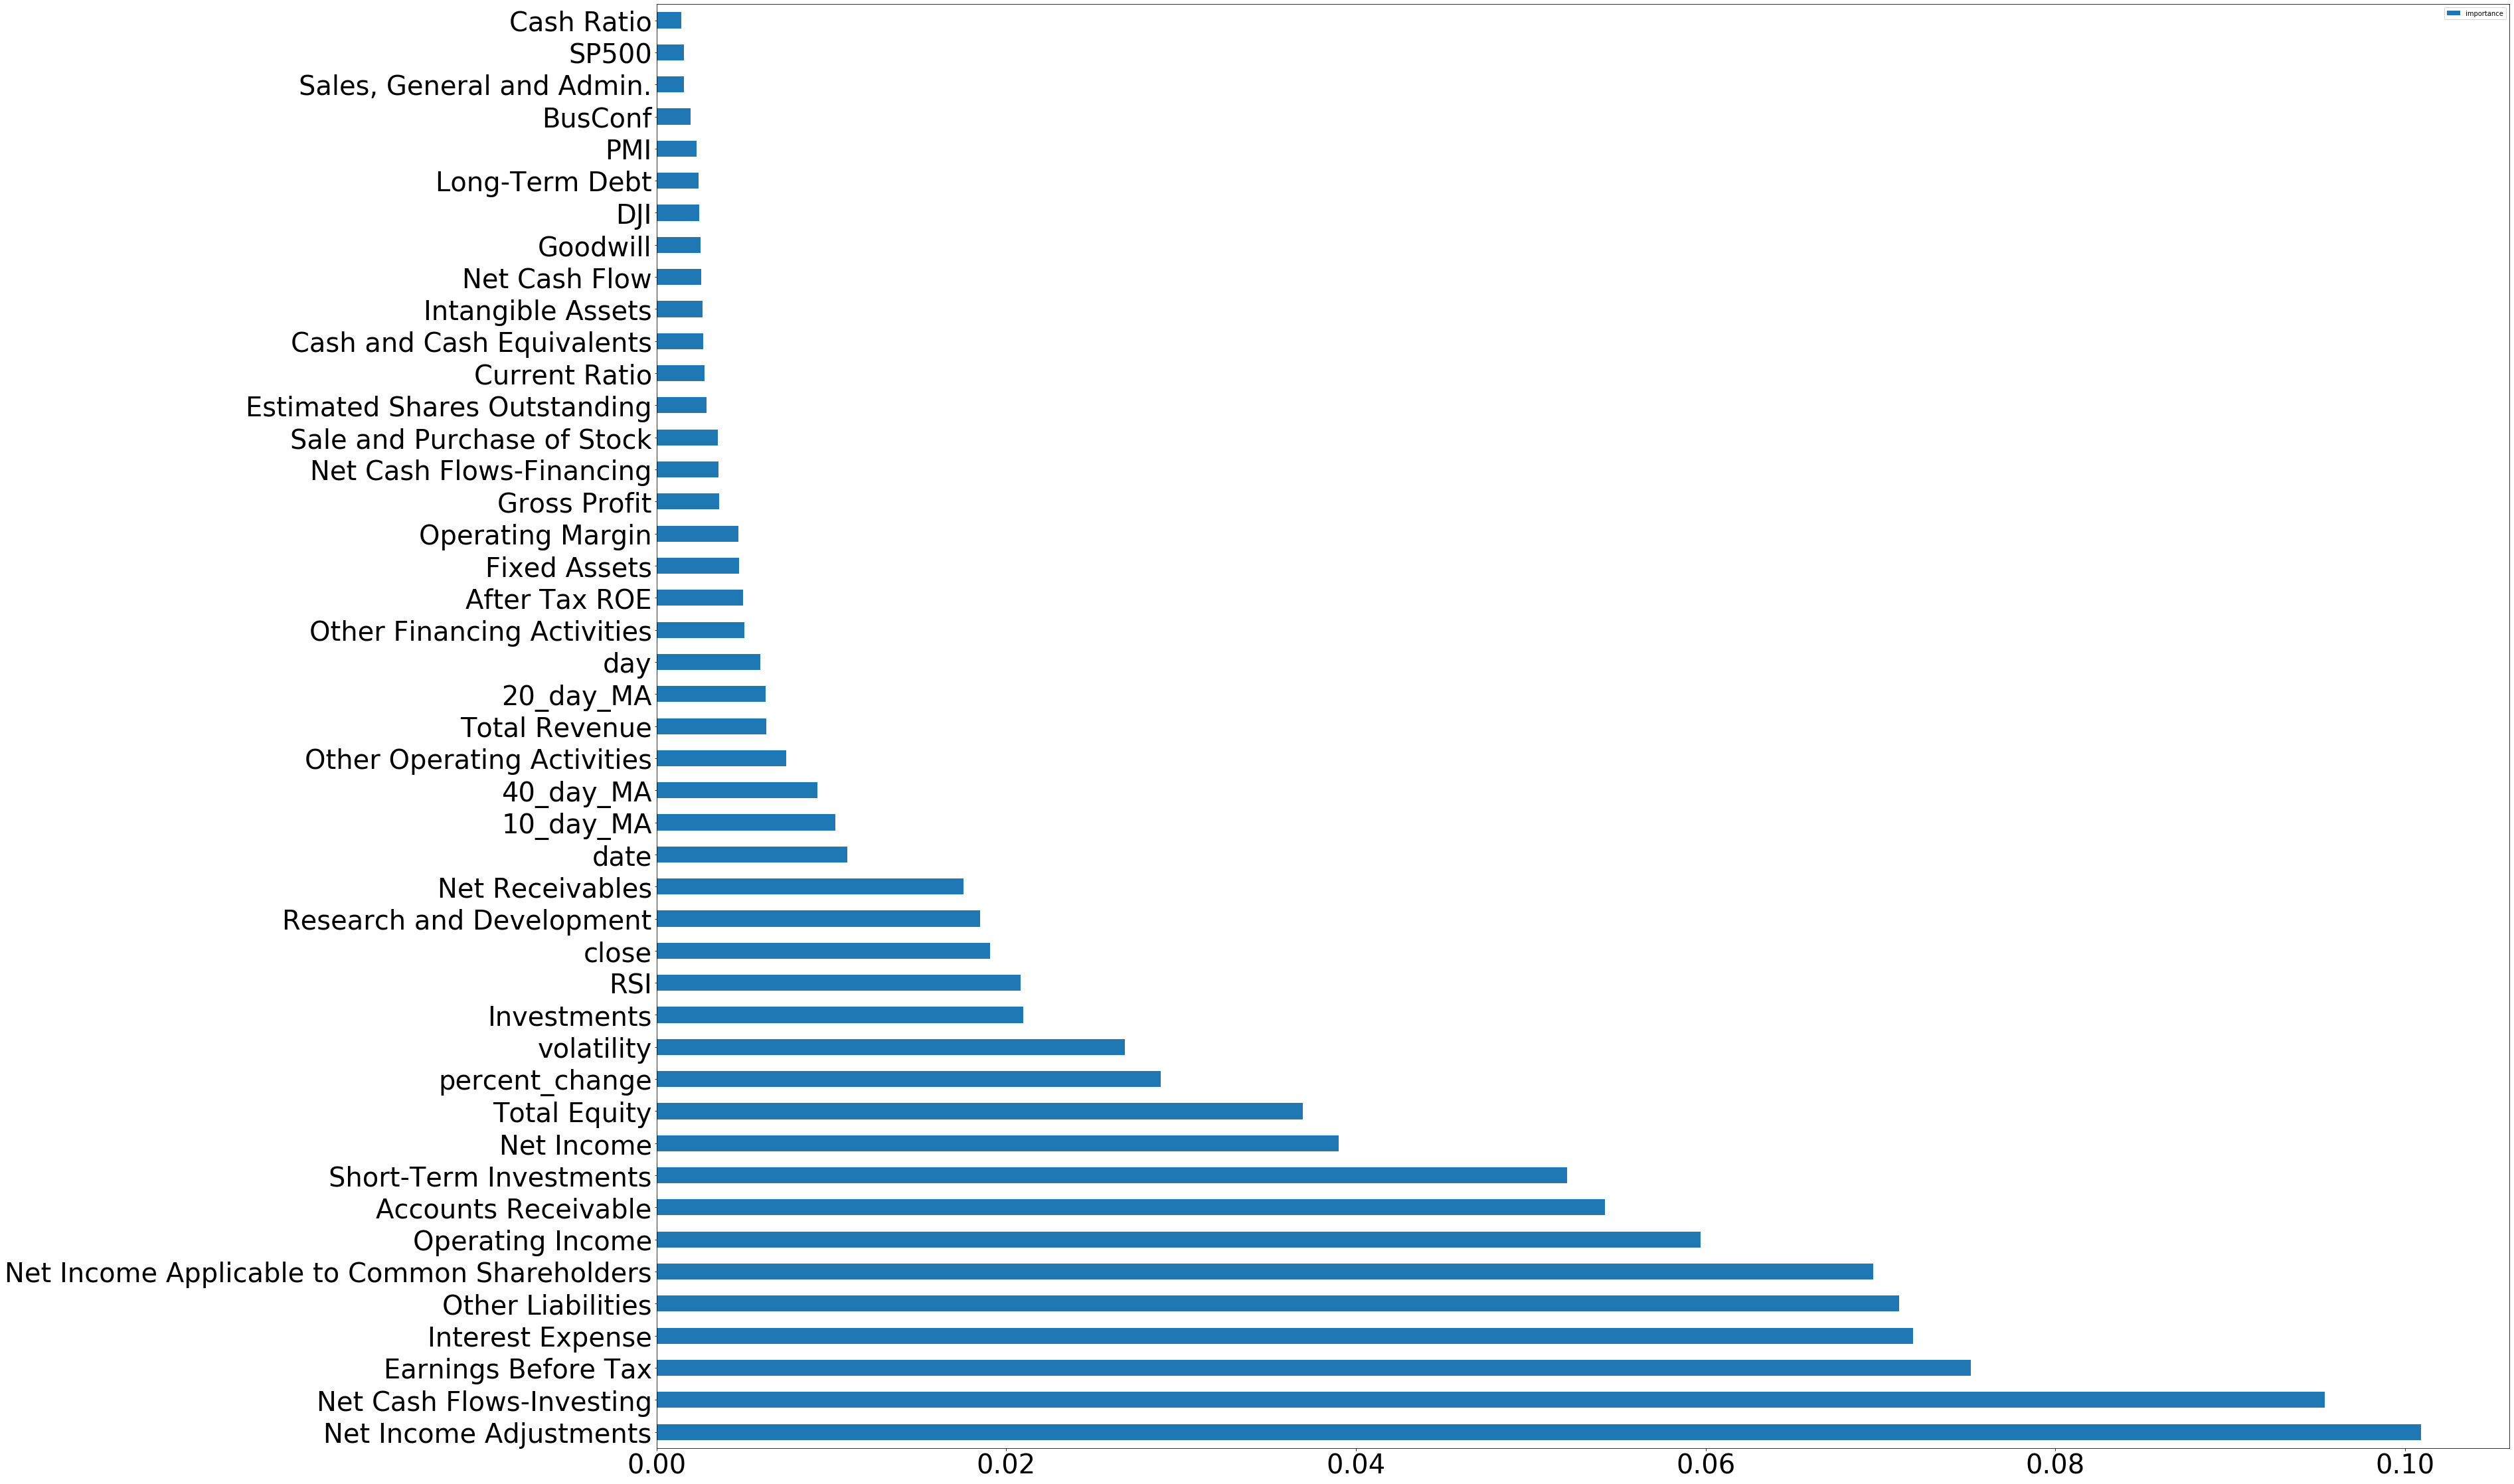

In [262]:
feature_importance = pd.DataFrame(model[2].feature_importances_, index = model[0].get_feature_names(), columns=['importance']).sort_values('importance', ascending=False)
feature_importance[feature_importance['importance'] > 0.0011].plot.barh(figsize=(50,40), fontsize=40)